In [14]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch
import torch.nn as nn
import torchvision
import cv2
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('/content/drive/MyDrive/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
pixel_data = data['pixels']
label_data = data['emotion']

In [5]:
def preprocess_pixels(pixel_data):
  images = []
  for i in range(len(pixel_data)):
    img = np.fromstring(pixel_data[i], dtype=np.uint8, sep=' ')
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    img = img.reshape(48,48,3)
    img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    #img = expand_greyscale_image_channels(img)
    #b,g,r = cv2.split(img)
    #img = cv2.merge([r,g,b])
    images.append(img)

  X = np.array(images)

 

  return X

In [6]:
oversampler = RandomOverSampler(sampling_strategy='auto')

X_over, Y_over = oversampler.fit_resample(pixel_data.values.reshape(-1,1), label_data)

X_over_series = pd.Series(X_over.flatten())

In [17]:
X = preprocess_pixels(X_over_series)
Y = Y_over
Y = Y.values.reshape(-1,1)

In [20]:
print("Images shape = ",X.shape,"\nLabels shape = ",Y.shape)
print(type(X),type(Y))

Images shape =  (62923, 48, 48, 3) 
Labels shape =  (62923, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


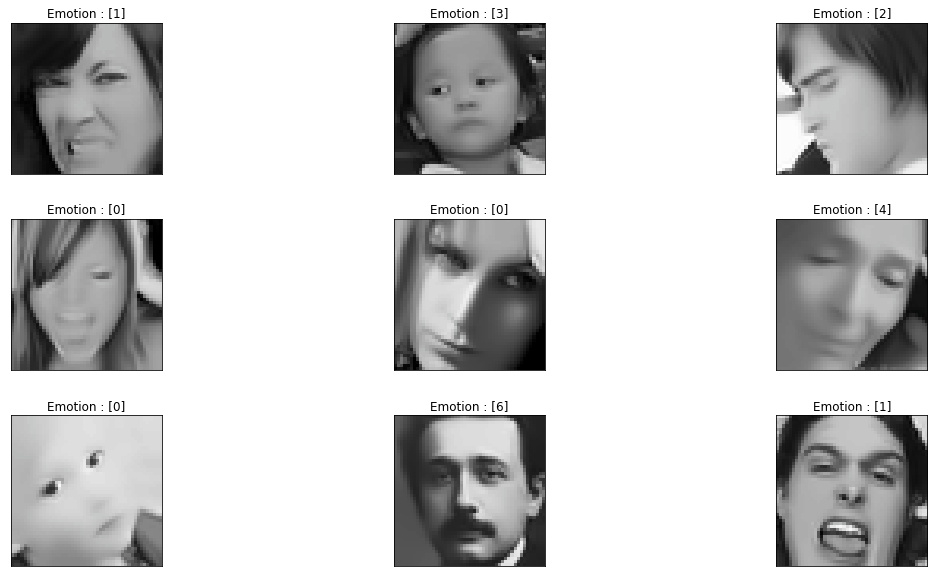

In [21]:
def display_rand_images(images, labels):
    
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Emotion : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(X, Y)
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 45)

print("x_train shape = ",X_train.shape)
print("y_train shape = ",Y_train.shape)
print("\nx_test shape = ",X_test.shape)
print("y_test shape = ",Y_test.shape)

x_train shape =  (50338, 48, 48, 3)
y_train shape =  (50338, 1)

x_test shape =  (12585, 48, 48, 3)
y_test shape =  (12585, 1)


In [55]:
X_train_tensor = torch.from_numpy(X_train)
Y_train_tensor = torch.from_numpy(Y_train)
X_test_tensor = torch.from_numpy(X_test)
Y_test_tensor = torch.from_numpy(Y_test)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)

In [56]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=16, pin_memory=True)
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=True, num_workers=16, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [57]:
# model class
class VGG16_CBAM(torch.nn.Module):

  # init function
  def __init__(self, model, num_classes=2):
    super().__init__()

    # pool layer
    self.pool = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=2, stride=2))

    # spatial attention
    self.spatial_attention = torch.nn.Sequential(
        torch.nn.Conv2d(2, 1, kernel_size=7, padding=3, stride=1),
        torch.nn.BatchNorm2d(1),
        torch.nn.Sigmoid()
    )

    # channel attention
    self.max_pool_1 = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=224, stride=224))
    self.max_pool_2 = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=112, stride=112))
    self.max_pool_3 = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=56, stride=56))
    self.max_pool_4 = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=28, stride=28))
    self.max_pool_5 = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=14, stride=14))
    self.avg_pool_1 = torch.nn.Sequential(torch.nn.AvgPool2d(kernel_size=224, stride=224))
    self.avg_pool_2 = torch.nn.Sequential(torch.nn.AvgPool2d(kernel_size=112, stride=112))
    self.avg_pool_3 = torch.nn.Sequential(torch.nn.AvgPool2d(kernel_size=56, stride=56))
    self.avg_pool_4 = torch.nn.Sequential(torch.nn.AvgPool2d(kernel_size=28, stride=28))
    self.avg_pool_5 = torch.nn.Sequential(torch.nn.AvgPool2d(kernel_size=14, stride=14))

    # features
    self.features_1 = torch.nn.Sequential(*list(model.features.children())[:3])
    self.features_2 = torch.nn.Sequential(*list(model.features.children())[3:6])
    self.features_3 = torch.nn.Sequential(*list(model.features.children())[7:10])
    self.features_4 = torch.nn.Sequential(*list(model.features.children())[10:13])
    self.features_5 = torch.nn.Sequential(*list(model.features.children())[14:17])
    self.features_6 = torch.nn.Sequential(*list(model.features.children())[17:20])
    self.features_7 = torch.nn.Sequential(*list(model.features.children())[20:23])
    self.features_8 = torch.nn.Sequential(*list(model.features.children())[24:27])
    self.features_9 = torch.nn.Sequential(*list(model.features.children())[27:30])
    self.features_10 = torch.nn.Sequential(*list(model.features.children())[30:33])
    self.features_11 = torch.nn.Sequential(*list(model.features.children())[34:37])
    self.features_12 = torch.nn.Sequential(*list(model.features.children())[37:40])
    self.features_13 = torch.nn.Sequential(*list(model.features.children())[40:43])

    self.avgpool = nn.AdaptiveAvgPool2d(7)

    # classifier
    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(25088, 4096),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(),
        torch.nn.Linear(4096, 4096),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(),
        torch.nn.Linear(4096, 2)
    )


  # forward
  def forward(self, x):
    x = self.features_1(x)
    scale = torch.nn.functional.sigmoid(self.max_pool_1(x) + self.avg_pool_1(x)).expand_as(x)
    x = x * scale
    scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
    scale = self.spatial_attention(scale)
    x = x * scale

    x = self.features_2(x)
    scale = torch.nn.functional.sigmoid(self.max_pool_1(x) + self.avg_pool_1(x)).expand_as(x)
    x = x * scale
    scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
    scale = self.spatial_attention(scale)
    x = x * scale
    x = self.pool(x)

    x = self.features_3(x)
    scale = torch.nn.functional.sigmoid(self.max_pool_2(x) + self.avg_pool_2(x)).expand_as(x)
    x = x * scale
    scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
    scale = self.spatial_attention(scale)
    x = x * scale

    x = self.features_4(x)
    scale = torch.nn.functional.sigmoid(self.max_pool_2(x) + self.avg_pool_2(x)).expand_as(x)
    x = x * scale
    scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
    scale = self.spatial_attention(scale)
    x = x * scale
    x = self.pool(x)

    x = self.features_5(x)
    scale = torch.nn.functional.sigmoid(self.max_pool_3(x) + self.avg_pool_3(x)).expand_as(x)
    x = x * scale
    scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
    scale = self.spatial_attention(scale)
    x = x * scale

    x = self.features_6(x)
    scale = torch.nn.functional.sigmoid(self.max_pool_3(x) + self.avg_pool_3(x)).expand_as(x)
    x = x * scale
    scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
    scale = self.spatial_attention(scale)
    x = x * scale

    x = self.features_7(x)
    scale = torch.nn.functional.sigmoid(self.max_pool_3(x) + self.avg_pool_3(x)).expand_as(x)
    x = x * scale
    scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
    scale = self.spatial_attention(scale)
    x = x * scale
    x = self.pool(x)

    x = self.features_8(x)
    scale = torch.nn.functional.sigmoid(self.max_pool_4(x) + self.avg_pool_4(x)).expand_as(x)
    x = x * scale
    scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
    scale = self.spatial_attention(scale)
    x = x * scale

    x = self.features_9(x)
    scale = torch.nn.functional.sigmoid(self.max_pool_4(x) + self.avg_pool_4(x)).expand_as(x)
    x = x * scale
    scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
    scale = self.spatial_attention(scale)
    x = x * scale

    x = self.features_10(x)
    scale = torch.nn.functional.sigmoid(self.max_pool_4(x) + self.avg_pool_4(x)).expand_as(x)
    x = x * scale
    scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
    scale = self.spatial_attention(scale)
    x = x * scale
    x = self.pool(x)

    x = self.features_11(x)
    scale = torch.nn.functional.sigmoid(self.max_pool_5(x) + self.avg_pool_5(x)).expand_as(x)
    x = x * scale
    scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
    scale = self.spatial_attention(scale)
    x = x * scale

    x = self.features_12(x)
    scale = torch.nn.functional.sigmoid(self.max_pool_5(x) + self.avg_pool_5(x)).expand_as(x)
    x = x * scale
    scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
    scale = self.spatial_attention(scale)
    x = x * scale

    x = self.features_13(x)
    scale = torch.nn.functional.sigmoid(self.max_pool_5(x) + self.avg_pool_5(x)).expand_as(x)
    x = x * scale
    scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
    scale = self.spatial_attention(scale)
    x = x * scale
    x = self.pool(x)

    x = self.avgpool(x)
    x = x.view(x.shape[0], -1)
    x = self.classifier(x)
    return x

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pretrained_model = torchvision.models.vgg16_bn(pretrained=True)
model = VGG16_CBAM(pretrained_model, 2)
model.to(device)
print(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG16_CBAM(
  (pool): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (spatial_attention): Sequential(
    (0): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
  )
  (max_pool_1): Sequential(
    (0): MaxPool2d(kernel_size=224, stride=224, padding=0, dilation=1, ceil_mode=False)
  )
  (max_pool_2): Sequential(
    (0): MaxPool2d(kernel_size=112, stride=112, padding=0, dilation=1, ceil_mode=False)
  )
  (max_pool_3): Sequential(
    (0): MaxPool2d(kernel_size=56, stride=56, padding=0, dilation=1, ceil_mode=False)
  )
  (max_pool_4): Sequential(
    (0): MaxPool2d(kernel_size=28, stride=28, padding=0, dilation=1, ceil_mode=False)
  )
  (max_pool_5): Sequential(
    (0): MaxPool2d(kernel_size=14, stride=14, padding=0, dilation=1, ceil_mode=False)
  )
  (avg_pool_1): Sequential(
    (0): AvgPool2d(kernel_size=224, s

In [59]:
# loss
criterion = torch.nn.CrossEntropyLoss()

In [60]:
# optimizer to be used
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

In [61]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []
best_metric = -1
best_metric_epoch = -1

# train and validate
for epoch in range(0, 30):
    
    # train
    model.train()
    training_loss = 0.0
    total = 0
    correct = 0
    for i, (input, target) in enumerate(train_loader):
        
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        training_loss = training_loss + loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
    training_loss = training_loss / float(len(train_loader))
    training_accuracy = str(100.0 * (float(correct) / float(total)))
    train_losses.append(training_loss)
    train_acc.append(training_accuracy)
    
    # validate
    model.eval()
    valid_loss = 0.0
    total = 0
    correct = 0
    for i, (input, target) in enumerate(val_loader):
        
        with torch.no_grad():
            input = input.to(device)
            target = target.to(device)

            output = model(input)
            loss = criterion(output, target)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
        valid_loss = valid_loss + loss.item()
    valid_loss = valid_loss / float(len(val_loader))
    valid_accuracy = str(100.0 * (float(correct) / float(total)))
    val_losses.append(valid_loss)
    val_acc.append(valid_accuracy)


    # store best model
    if(float(valid_accuracy) > best_metric and epoch >= 10):
      best_metric = float(valid_accuracy)
      best_metric_epoch = epoch
      torch.save(model.state_dict(), "best_model.pth")
    
    print()
    print("Epoch" + str(epoch) + ":")
    print("Training Accuracy: " + str(training_accuracy) + "    Validation Accuracy: " + str(valid_accuracy))
    print("Training Loss: " + str(training_loss) + "    Validation Loss: " + str(valid_loss))
    print()

RuntimeError: ignored